## FIFA Player Data Analysis Project - Dimensionality Reduction and Player Skill Visualization

### Project Goal
The main goal of this project is to analyze and visualize FIFA player skills, focusing exclusively on their on-field attributes and technical abilities. The project deliberately omits players' personal, physical, and economic data (such as height, weight, nationality, or market value) to concentrate on a pure analysis of football skills.

The project utilizes advanced dimensionality reduction techniques:
- PCA (Principal Component Analysis)
- Classical MDS (Multidimensional Scaling)
- Non-metric MDS

### Data
The "Football Players Data" dataset from Kaggle was used for the analysis:

https://www.kaggle.com/datasets/maso0dahmed/football-players-data

### Scope of Analyzed Data
The analysis covers the following skill categories:
1. Technical Skills:
   - Dribbling, passing, shooting
   - Ball control, accuracy
2. Physical Attributes in the Context of Play:
   - Acceleration, agility
   - Shot power, stamina
3. Mental Traits:
   - Aggression, composure
   - Vision, game intelligence

Traits not directly related to football skills were omitted:
- Personal data (first name, last name, date of birth)
- Physical parameters (height, weight)
- Club/national team data
- Economic aspects (value, wage, release clause)
- Preferential traits (preferred foot, body type)

This approach allows for an objective analysis of pure football skills, without the influence of external or marketing factors.

In [33]:
import plotly.io as pio
pio.renderers.default = "notebook_connected"

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import PCA
import plotly.graph_objects as go
from sklearn.manifold import MDS
from factor_analyzer import calculate_kmo
from plotly.subplots import make_subplots
import plotly.express as px
import plotly.subplots as sp
from sklearn.metrics import pairwise_distances
from sklearn.metrics import euclidean_distances
from IPython.display import display, HTML

pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)

data = pd.read_csv("fifa_players.csv")

print("Basic data information:")
data.info()

Basic data information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17954 entries, 0 to 17953
Data columns (total 51 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   name                           17954 non-null  object 
 1   full_name                      17954 non-null  object 
 2   birth_date                     17954 non-null  object 
 3   age                            17954 non-null  int64  
 4   height_cm                      17954 non-null  float64
 5   weight_kgs                     17954 non-null  float64
 6   positions                      17954 non-null  object 
 7   nationality                    17954 non-null  object 
 8   overall_rating                 17954 non-null  int64  
 9   potential                      17954 non-null  int64  
 10  value_euro                     17699 non-null  float64
 11  wage_euro                      17708 non-null  float64
 12  preferred_foot        

The dataset is dominated by numerical variables, but there are also columns of type object.


## Exploratory Data Analysis

In [34]:
print(data.duplicated().sum())

0


The data is unique for each row, which simplifies further analysis.

In [35]:
data = data.drop(columns=['full_name', 'birth_date', 'positions', 'nationality','national_team',
           'national_team_position', 'national_rating', 'national_jersey_number', 'value_euro',
           'wage_euro','release_clause_euro','international_reputation(1-5)','age','height_cm', 'weight_kgs', 'preferred_foot', 'body_type'])

In [36]:
print("Missing values:")
print(data.isnull().sum().sort_values(ascending=False))

Missing values:
name                 0
aggression           0
balance              0
shot_power           0
jumping              0
stamina              0
strength             0
long_shots           0
interceptions        0
overall_rating       0
positioning          0
vision               0
penalties            0
composure            0
marking              0
standing_tackle      0
reactions            0
agility              0
sprint_speed         0
acceleration         0
ball_control         0
long_passing         0
freekick_accuracy    0
curve                0
dribbling            0
volleys              0
short_passing        0
heading_accuracy     0
finishing            0
crossing             0
skill_moves(1-5)     0
weak_foot(1-5)       0
potential            0
sliding_tackle       0
dtype: int64


Columns not directly related to on-field and technical skills were removed.
Data does not contain missing values.


In [37]:
print(data.dtypes.value_counts())
data.head()

int64     33
object     1
Name: count, dtype: int64


name  overall_rating  potential  weak_foot(1-5)  skill_moves(1-5)  crossing  finishing  heading_accuracy  short_passing  volleys  dribbling  curve  freekick_accuracy  long_passing  ball_control  acceleration  sprint_speed  agility  reactions  balance  shot_power  jumping  stamina  strength  long_shots  aggression  interceptions  positioning  vision  penalties  composure  marking  standing_tackle  sliding_tackle
0      L. Messi              94         94               4                 4        86         95                70             92       86         97     93                 94            89            96            91            86       93         95       95          85       68       72        66          94          48             22           94      94         75         96       33               28              26
1    C. Eriksen              88         89               5                 4        88         81                52             91       80         84     86                 87            89            91            76            73       80         88       81          84       50       92        58          89          46             56           84      91         67         88       59               57              22
2      P. Pogba              88         91               4                 5        80         75                75             86       85         87     85                 82            90            90            71            79       76         82       66          90       83       88        87          82          78             64           82      88         82         87       63               67              67
3    L. Insigne              88         88               4                 4        86         77                56             85       74         90     87                 77            78            93            94            86       94         83       93          75       53       75        44          84          34             26           83      87         61         83       51               24              22
4  K. Koulibaly              88         91               3                 2        30         22                83             68       14         69     28                 28            60            63            70            75       50         82       40          55       81       75        94          15          87             88           24      49         33         80       91               88              87

The data is in the appropriate formats for further numerical analysis, except for the name column, which is used only for player identification.

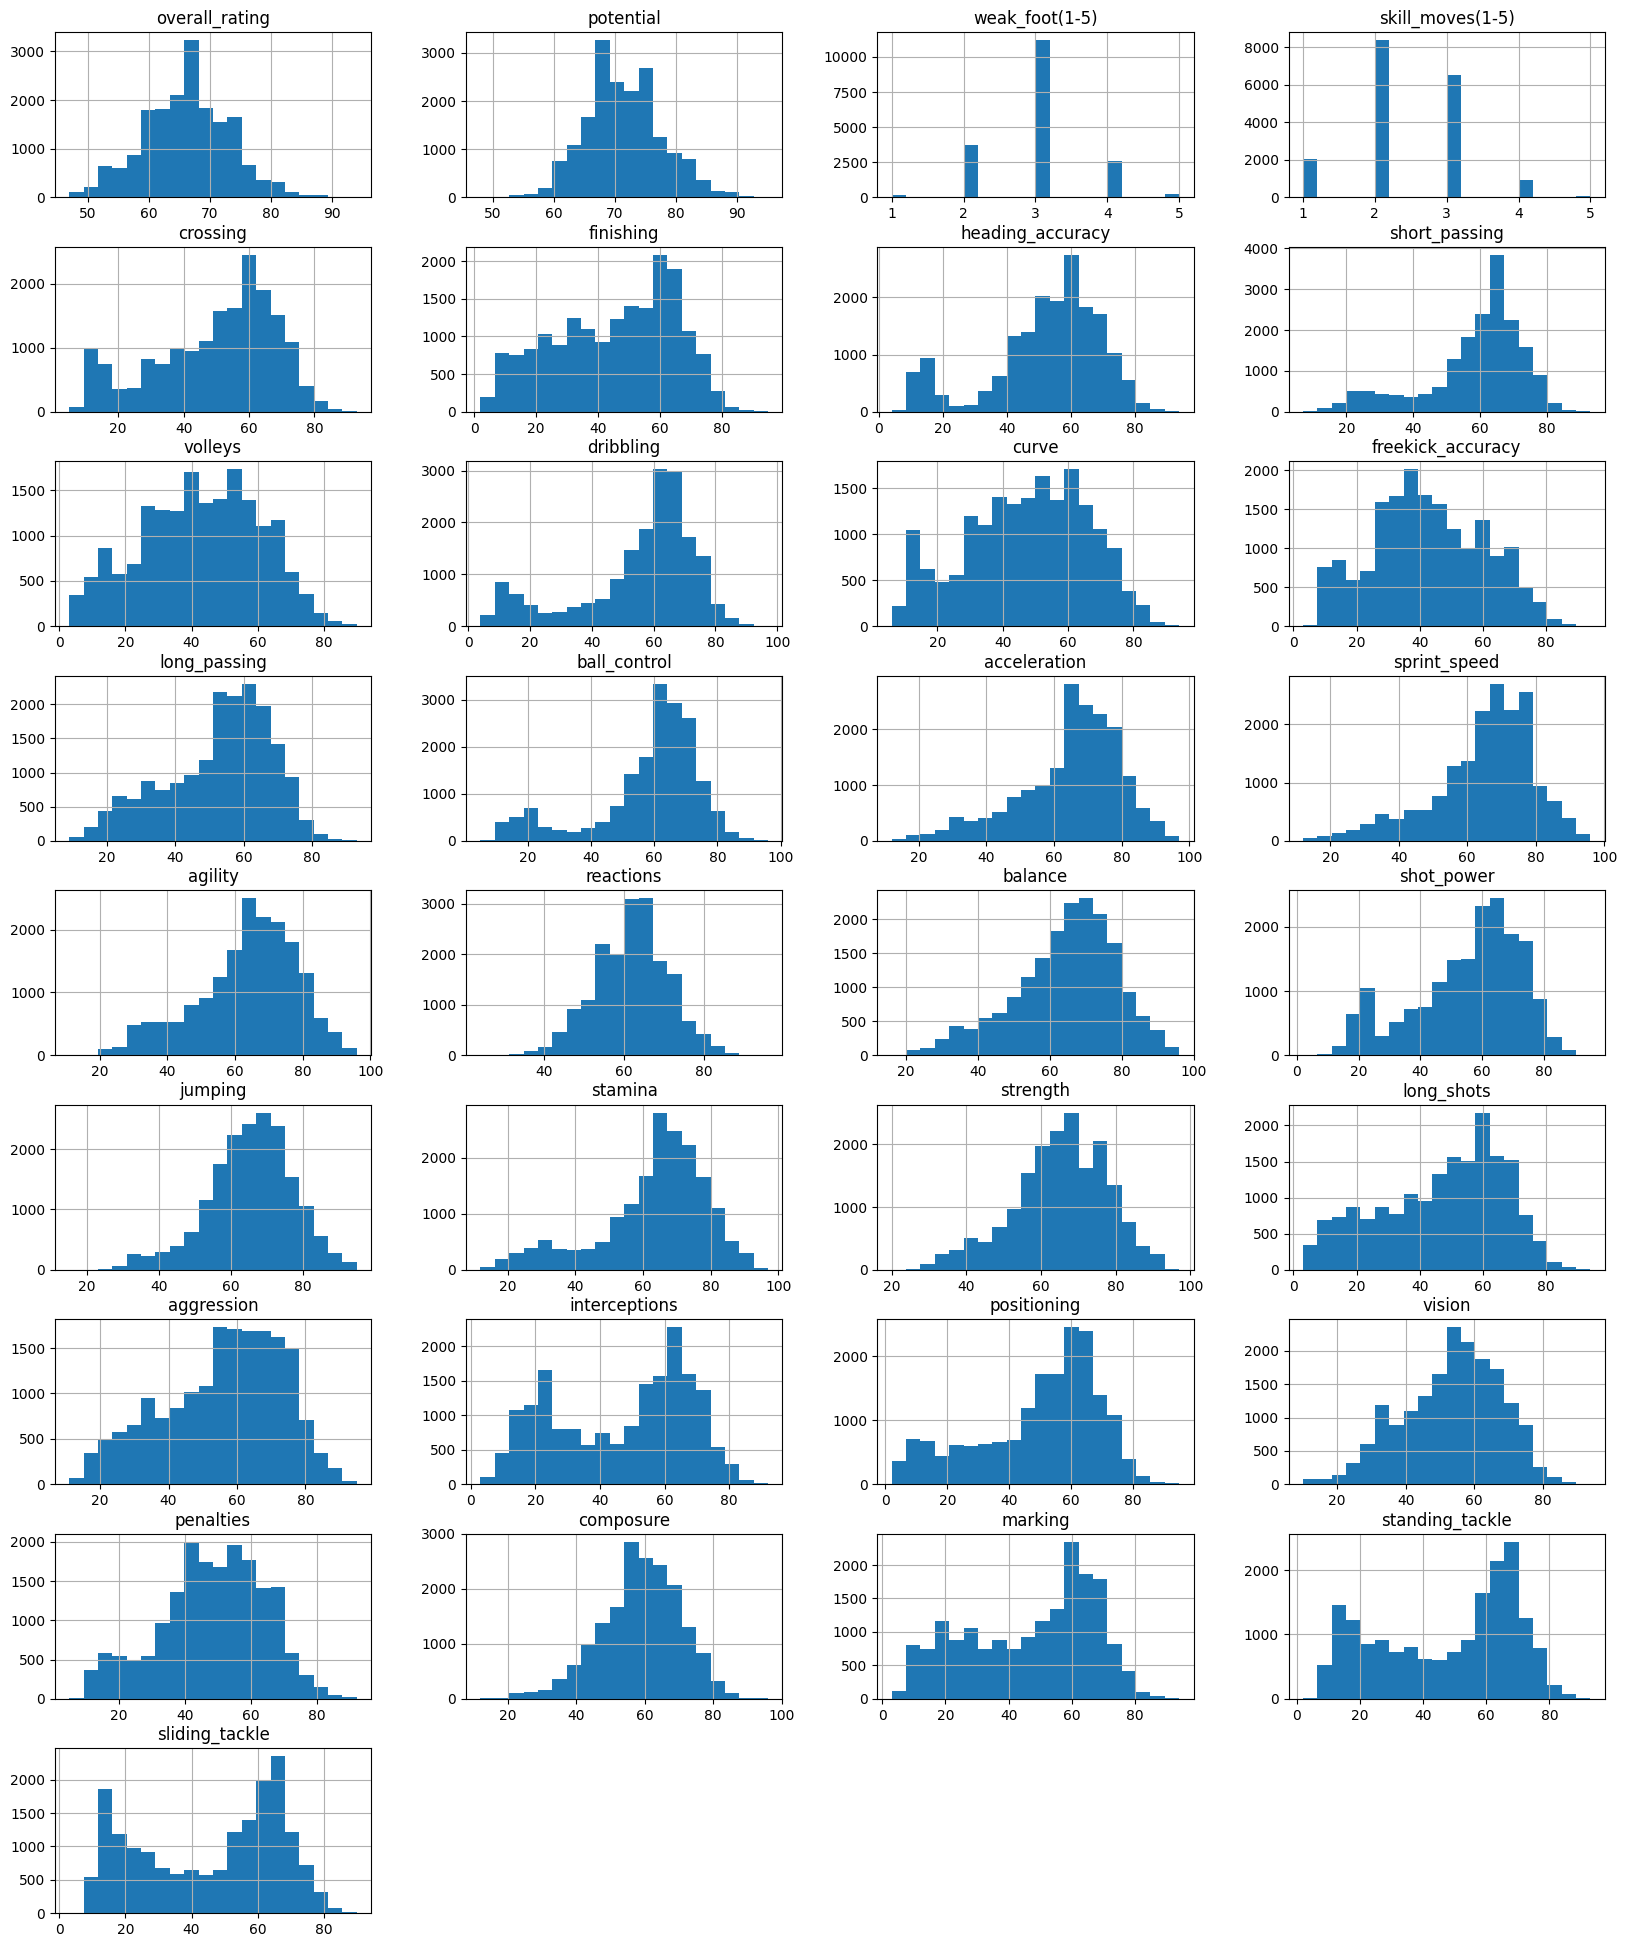

In [38]:
# Histograms of numerical variables
data.hist(bins=20, figsize=(20, 30), layout=(11, 4))
plt.show()

Most skills have a distribution close to normal, although some may be skewed (e.g., overall_rating and potential tend to concentrate at higher values).

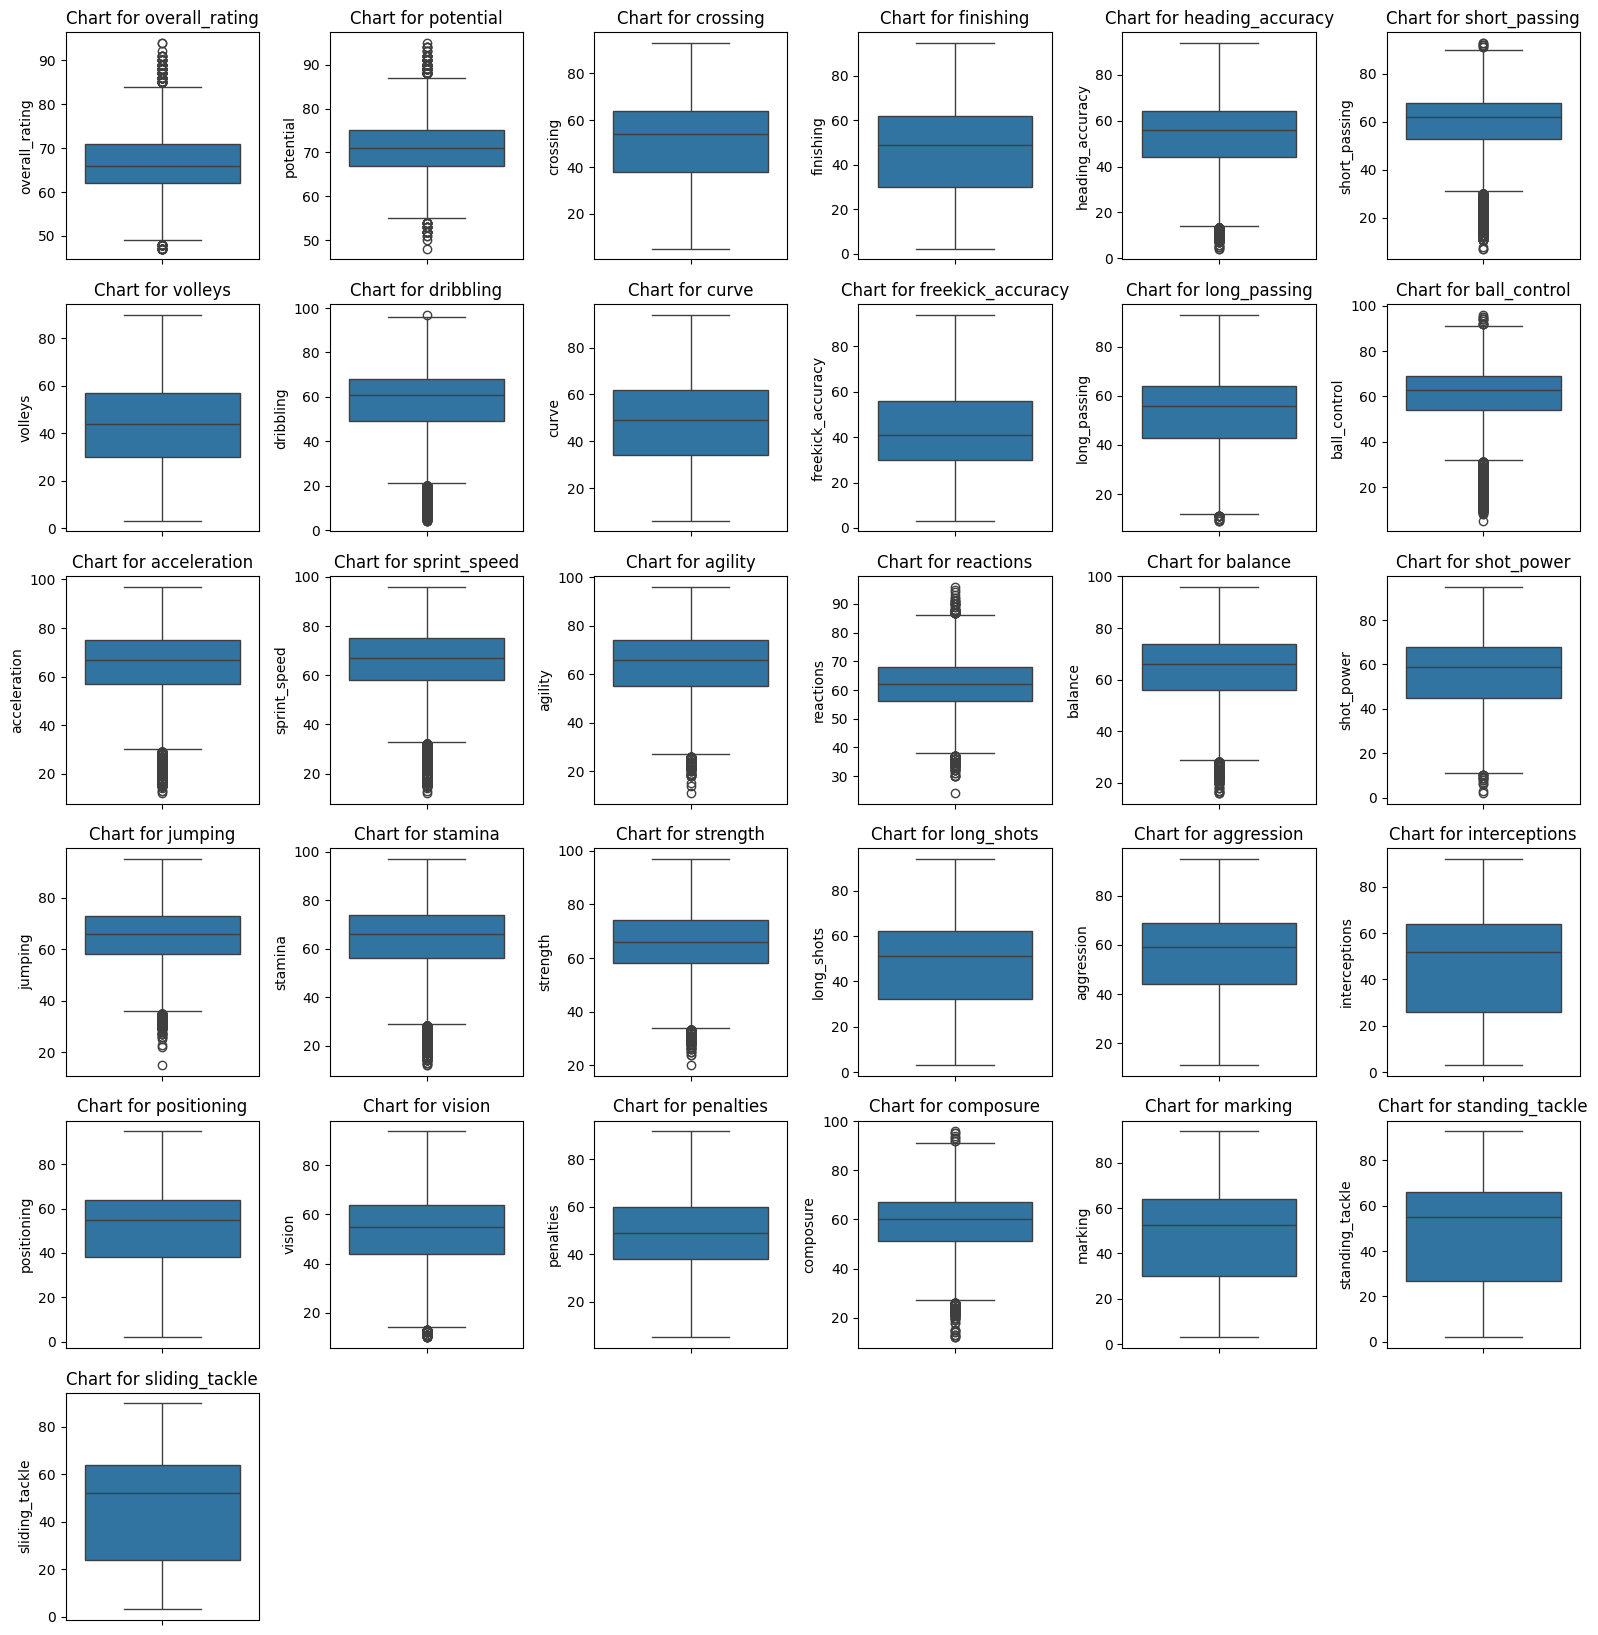

In [39]:
# Box plots for numerical variables
numerical_columns = data.drop(columns=['weak_foot(1-5)', 'skill_moves(1-5)', 'name'])

plt.figure(figsize=(16, 30))
for i, column in enumerate(numerical_columns.columns, 1):
    plt.subplot(len(numerical_columns.columns) // 3 + 1, 6, i)
    sns.boxplot(y=numerical_columns[column])
    plt.title(f'Chart for {column}')
plt.tight_layout()
plt.show()

Box plots confirm the presence of outliers in many numerical columns. Removing these outliers, as planned in later steps, is justified to obtain more stable results from the dimensionality reduction analysis.

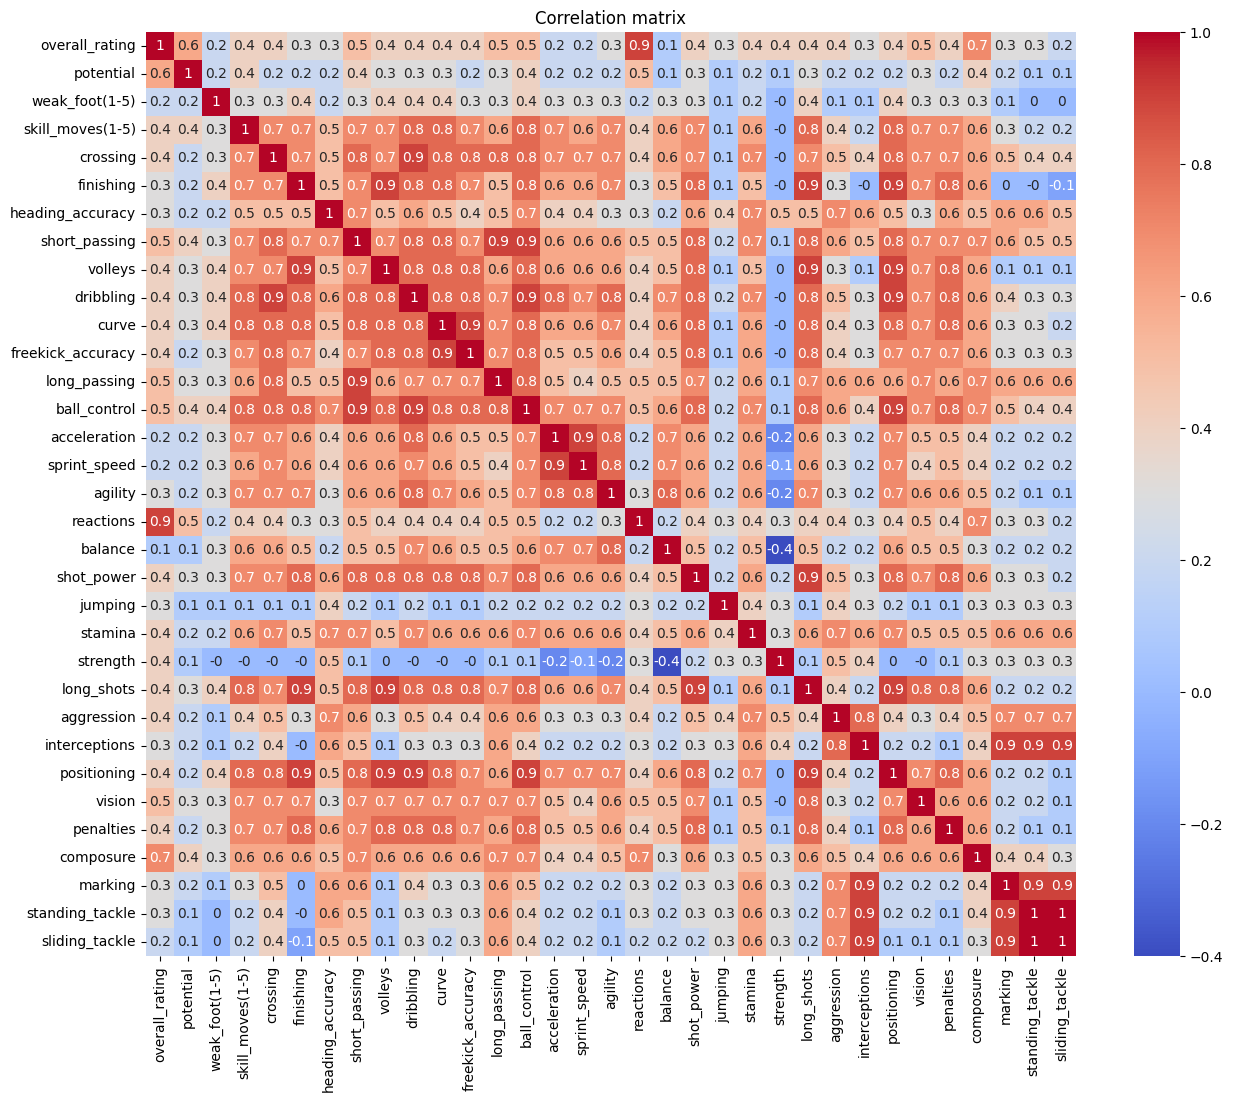

In [40]:
data_no_name = data.drop(columns='name')
corr_matrix = data_no_name.corr()

plt.figure(figsize=(15, 12))
sns.heatmap(corr_matrix.round(1), annot=True, cmap="coolwarm")
plt.title("Correlation matrix")
plt.show()

*   Many on-field skills are strongly correlated with each other (e.g., dribbling with ball_control, short_passing with vision, marking with standing_tackle). This is expected as many skills are interrelated in football gameplay.
*   overall_rating is strongly correlated with many skills, suggesting it is a good measure of a player's overall level.
*   weak_foot(1-5) and skill_moves(1-5) have lower correlations with most other skills, which may suggest they are more independent traits.

### Checking if variables are significantly correlated

In [41]:
# Calculating KMO coefficients
kmo_all, kmo_model = calculate_kmo(data_no_name)

kmo_table = pd.DataFrame({
    'Variable': data_no_name.columns,
    'KMO value': kmo_all
})

print("KMO Value for Each Variable:")
print(kmo_table.sort_values(by='KMO value', ascending=True))
print(f"\nKMO Value for the Entire Dataset: {kmo_model}")

KMO Value for Each Variable:
             Variable  KMO value
22           strength   0.837652
0      overall_rating   0.866812
1           potential   0.873593
31    standing_tackle   0.899356
20            jumping   0.899462
32     sliding_tackle   0.904767
17          reactions   0.916115
14       acceleration   0.933145
15       sprint_speed   0.934849
6    heading_accuracy   0.951463
18            balance   0.957829
12       long_passing   0.962806
25      interceptions   0.964330
7       short_passing   0.967629
5           finishing   0.973288
13       ball_control   0.973385
9           dribbling   0.974514
23         long_shots   0.974832
11  freekick_accuracy   0.975586
26        positioning   0.978110
10              curve   0.978915
27             vision   0.978959
16            agility   0.979186
19         shot_power   0.979933
4            crossing   0.980750
24         aggression   0.983179
29          composure   0.983556
30            marking   0.983834
28          pe

Kaiser-Meyer-Olkin coefficients are greater than 0.7, so all variables are significantly correlated.

### Removing outliers to obtain more stable, consistent, and interpretable analysis results

In [42]:
numerical_columns = data_no_name.drop(columns=['weak_foot(1-5)', 'skill_moves(1-5)'])
data_to_check = numerical_columns

Q1 = data_to_check.quantile(0.25)
Q3 = data_to_check.quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers = ((data_to_check < lower_bound) | (data_to_check > upper_bound))

data_no_outliers = data[~outliers.any(axis=1)]
print(f"Shape of data after removing outliers: {data_no_outliers.shape}")

data = data_no_outliers

print("Data after removing outliers:")
data.reset_index(drop=True, inplace=True)
data.info()

Shape of data after removing outliers: (14979, 34)
Data after removing outliers:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14979 entries, 0 to 14978
Data columns (total 34 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   name               14979 non-null  object
 1   overall_rating     14979 non-null  int64 
 2   potential          14979 non-null  int64 
 3   weak_foot(1-5)     14979 non-null  int64 
 4   skill_moves(1-5)   14979 non-null  int64 
 5   crossing           14979 non-null  int64 
 6   finishing          14979 non-null  int64 
 7   heading_accuracy   14979 non-null  int64 
 8   short_passing      14979 non-null  int64 
 9   volleys            14979 non-null  int64 
 10  dribbling          14979 non-null  int64 
 11  curve              14979 non-null  int64 
 12  freekick_accuracy  14979 non-null  int64 
 13  long_passing       14979 non-null  int64 
 14  ball_control       14979 non-null  int64 
 15  accele

### Standardization of variables to ensure all data are on the same scale, which prevents variables with larger variance from dominating the analysis

In [43]:
columns_to_standardize = data_no_name.columns

scaler = StandardScaler()
data[columns_to_standardize] = scaler.fit_transform(data[columns_to_standardize])

data.head()

name  overall_rating  potential  weak_foot(1-5)  skill_moves(1-5)  crossing  finishing  heading_accuracy  short_passing   volleys  dribbling     curve  freekick_accuracy  long_passing  ball_control  acceleration  sprint_speed   agility  reactions   balance  shot_power   jumping   stamina  strength  long_shots  aggression  interceptions  positioning    vision  penalties  composure   marking  standing_tackle  sliding_tackle
0    H. Ziyech        2.714519   2.484214       -1.584602          2.403249  2.133340   1.126017         -0.375498       2.506459  2.076935   1.941640  2.592602           2.121335      2.719777      2.086824      0.685890      0.508981  1.653158   2.478350  0.979633    1.555402 -2.708322  1.718042 -0.606598    1.581430    0.855658       0.606882     1.458286  2.583464   1.608283   2.294305  0.033842         0.724156       -0.734775
1    T. Werner        2.714519   2.656635        1.561290          0.766220  1.050105   2.300775          1.747288       1.533099  2.625709   1.857762  0.781303           0.645802     -0.108890      2.193150      2.219166      2.278134  1.227499   2.837425  0.807428    1.402184  1.086436  1.436045 -0.183542    1.194589    0.218885      -0.731041     2.084700  0.431368   1.608283   1.374401 -0.721882        -1.694755       -1.628873
2  Alex Telles        2.714519   2.484214       -1.584602          0.766220  2.494418   0.940529          1.481940       2.182006  1.390967   1.773883  2.391347           2.188405      2.470188      1.980498      1.407432      1.533227  0.546444   2.478350  0.290813    1.555402  1.371043  2.282035  0.154903    1.516956    1.280174       1.570187     1.458286  1.467563   1.689031   1.987670  1.661555         1.512931        1.526768
3     Jorginho        2.559392   2.139372       -0.011656          0.766220  1.483399   0.445895         -0.110150       2.830913  1.665354   1.773883  1.586325           1.987195      2.553385      2.299475      0.144733     -0.701492  0.886971   2.358659  0.549121    0.865922 -0.810943  1.060050 -0.014319    0.678802    1.350927       1.356119     0.901474  2.503757   2.577266   1.885459  0.615168         1.302591        1.053422
4     E. Višća        2.559392   1.966951        1.561290          2.403249  1.844477   1.867970         -1.083093       2.073855  1.871145   1.773883  1.519240           0.914080      1.222247      1.980498      1.948588      1.905681  2.249082   2.119275  1.840657    1.478793  0.232615  1.530044 -0.691209    1.645903   -0.913157       0.071713     1.945497  1.706684   1.850529   2.192094  0.208240        -0.643055       -0.524399

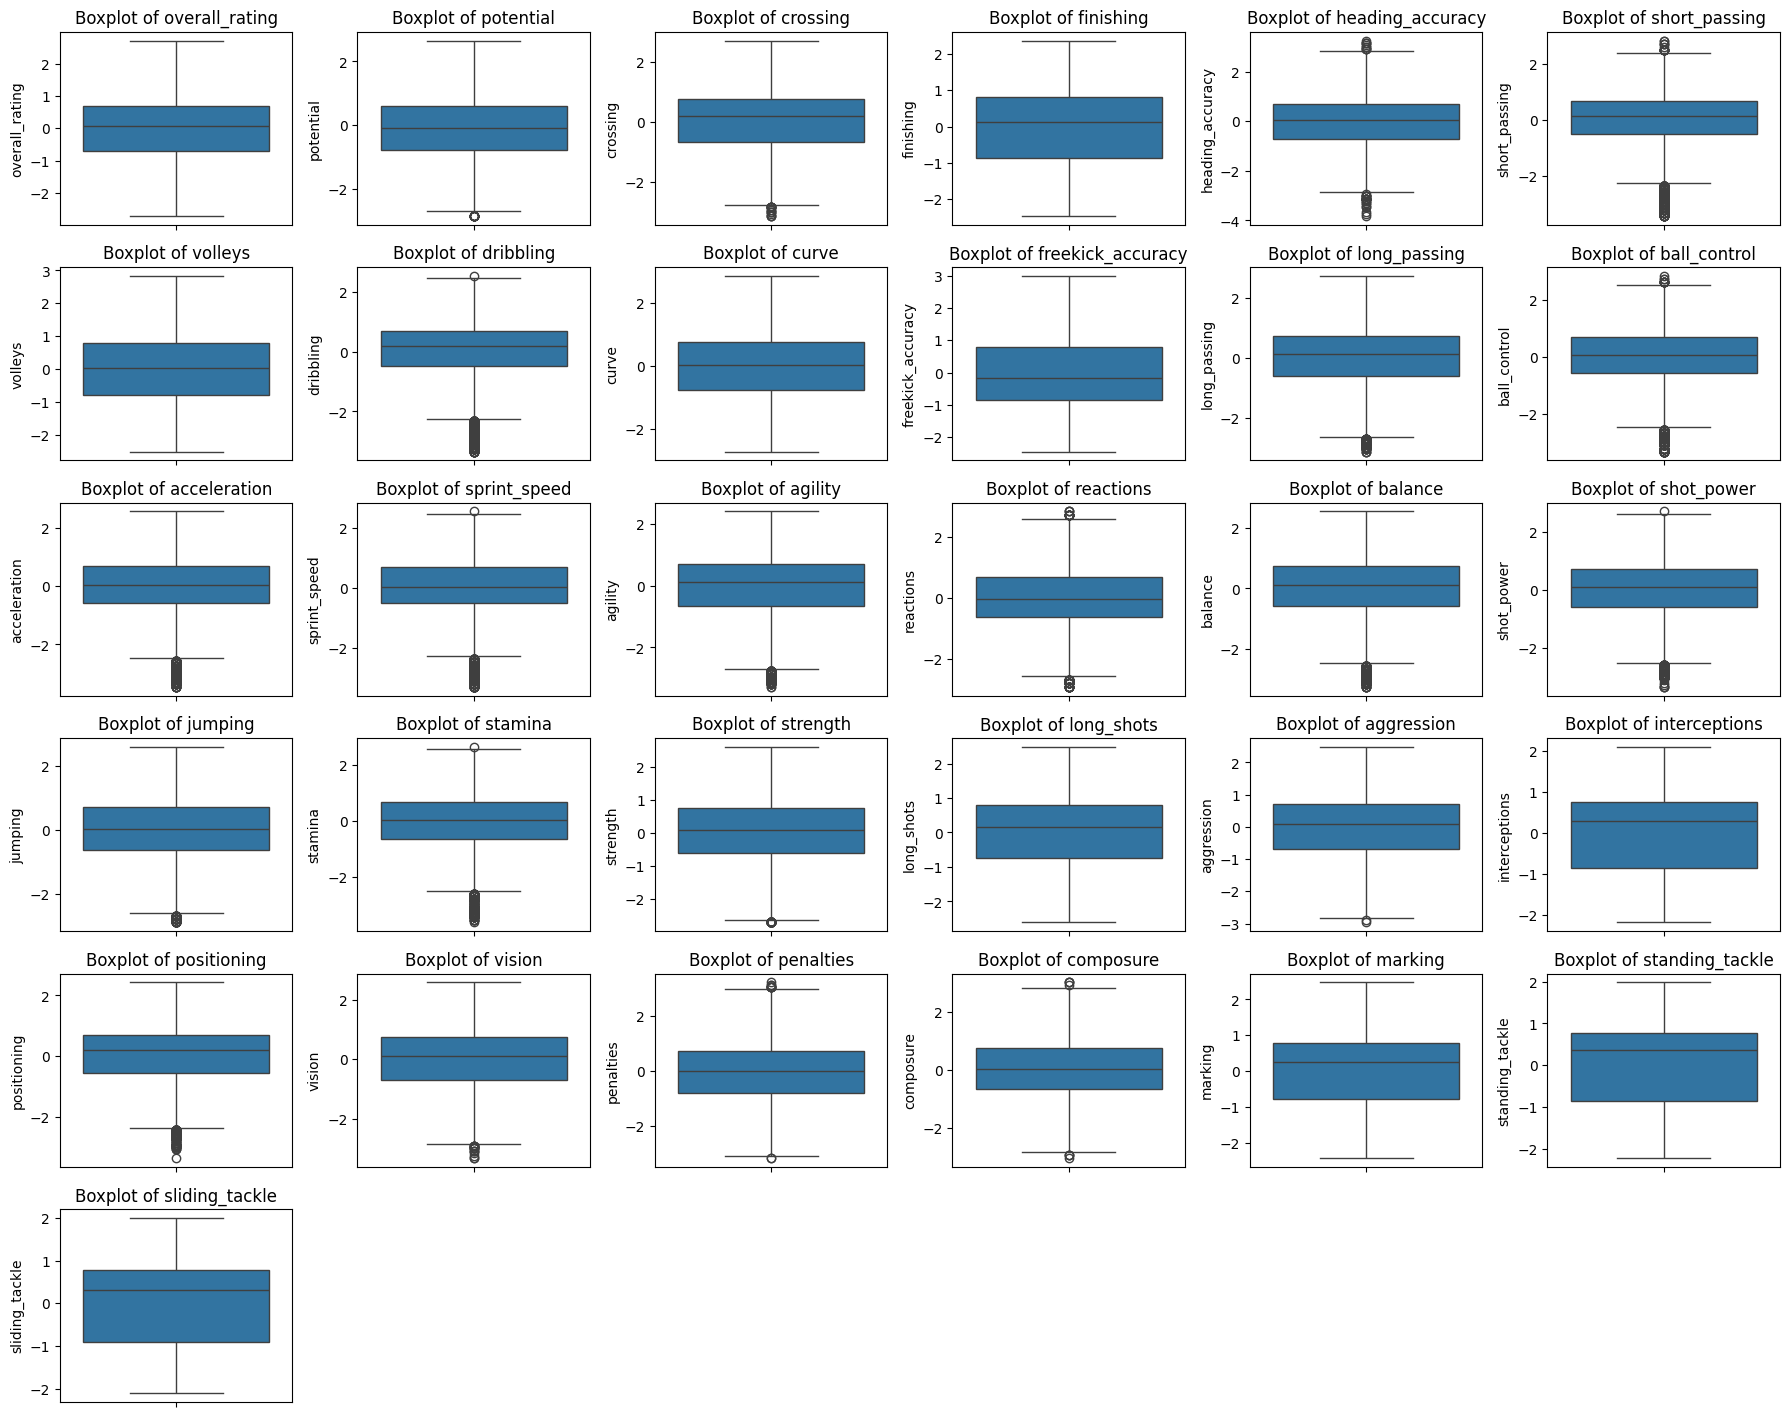

In [44]:
numerical_columns = data.drop(columns=['weak_foot(1-5)', 'skill_moves(1-5)', 'name'])

plt.figure(figsize=(18, 26))
for i, column in enumerate(numerical_columns.columns, 1):
    plt.subplot(len(numerical_columns.columns) // 3 + 1, 6, i)
    sns.boxplot(y=numerical_columns[column])
    plt.title(f'Boxplot of {column}')
plt.tight_layout()
plt.show()

# PCA  
**Description**  
Principal Component Analysis (PCA) is a dimensionality reduction method that transforms data in such a way as to maximize variance along successive axes (principal components). The result is a set of new, orthogonal axes that can be used to analyze data with a reduced number of dimensions.

**How it works**

- PCA computes the covariance matrix of the data.  
- Eigenvalues and eigenvectors of the covariance matrix are then calculated.  
- The data are transformed onto the axes with the highest variance.

**Advantages**

- **Simplicity and computational efficiency:** Fast to implement, especially for large datasets.  
- **Interpretability:** Reduces dimensionality while preserving as much information as possible.  
- **Versatility:** Used in image analysis, genetic data, finance, and many other fields.

**Disadvantages**

- **Linearity assumption:** PCA works best for data with linear structures.  
- **Sensitivity to scaling:** Data must be standardized; otherwise, variables with large scales will dominate.  
- **Lack of intuitive interpretation:** Principal components are linear combinations of variables, which can make interpretation difficult.


   Component  Explained Variance  Cumulative Variance
0        PC1            0.373210             0.373210
1        PC2            0.200211             0.573422
2        PC3            0.089520             0.662942
3        PC4            0.055820             0.718761
4        PC5            0.034537             0.753298
5        PC6            0.027262             0.780560
6        PC7            0.023706             0.804265
7        PC8            0.017762             0.822028
8        PC9            0.015249             0.837277
9       PC10            0.014827             0.852104
10      PC11            0.013365             0.865469
11      PC12            0.012862             0.878331
12      PC13            0.011945             0.890277
13      PC14            0.010237             0.900514
14      PC15            0.009611             0.910124
15      PC16            0.008579             0.918703
16      PC17            0.008171             0.926874
17      PC18            0.00

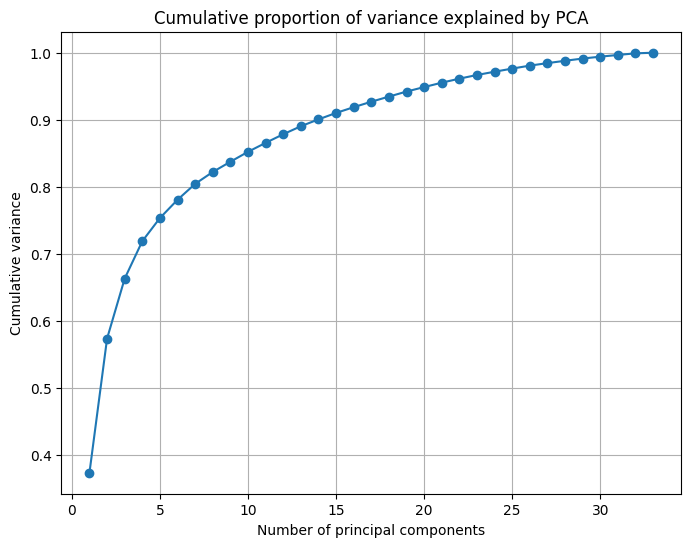

In [45]:
data_with_name = data.copy()
data = data.drop(columns='name')
pca = PCA()

pca_transformed = pca.fit_transform(data)

explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance_ratio)

explained_variance_table = pd.DataFrame({
    "Component": [f"PC{i+1}" for i in range(len(explained_variance_ratio))],
    "Explained Variance": explained_variance_ratio,
    "Cumulative Variance": cumulative_variance
})
print(explained_variance_table)

plt.figure(figsize=(8, 6))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o')
plt.title("Cumulative proportion of variance explained by PCA")
plt.xlabel("Number of principal components")
plt.ylabel("Cumulative variance")
plt.grid()
plt.show()

Reducing the data to 6 dimensions is an appropriate choice.  
These 6 dimensions explain over 80% of the total variance, which is a good result compared to the original 32 features.


In [46]:
loadings = pca.components_.T

loadings_df = pd.DataFrame(loadings, columns=[f'PC{i+1}' for i in range(loadings.shape[1])], index=data.columns)

print("Factor Loadings (Eigenvectors):")
display(loadings_df.iloc[:, :10])

Factor Loadings (Eigenvectors):


PC1       PC2       PC3       PC4       PC5       PC6       PC7       PC8       PC9      PC10
overall_rating     0.189898  0.222089  0.097214  0.165908  0.210745 -0.006888  0.039548  0.021284 -0.106415 -0.097550
potential          0.122040  0.104578  0.002085  0.157593  0.651787 -0.008396  0.114058  0.172163  0.449053 -0.033428
weak_foot(1-5)     0.097084 -0.024616  0.032603 -0.009779  0.037442  0.946160 -0.290813  0.054680  0.004079 -0.001406
skill_moves(1-5)   0.217889 -0.031715 -0.044146  0.022430  0.199876 -0.013300 -0.001946  0.044601 -0.362053 -0.038879
crossing           0.207258  0.061363 -0.206870 -0.093966 -0.100534 -0.072993 -0.121276  0.173366 -0.366625  0.154706
finishing          0.225211 -0.142942  0.183576  0.026342 -0.052874 -0.031064 -0.030661 -0.077279  0.115931 -0.033831
heading_accuracy  -0.000204  0.202776  0.353460  0.250195  0.042464 -0.012272  0.069931  0.119175 -0.073333  0.041270
short_passing      0.209369  0.175842 -0.049048 -0.147193  0.131935  0.003644  0.037958 -0.264946  0.087424  0.258561
volleys            0.229245 -0.078735  0.180136 -0.023471 -0.103722 -0.015288  0.034454  0.120590  0.060046 -0.086172
dribbling          0.253183 -0.043294 -0.085949  0.005102  0.084538 -0.062030 -0.060536 -0.085597 -0.118803  0.123439
curve              0.238886  0.003263 -0.036723 -0.151297 -0.131930 -0.032705  0.008588  0.303123 -0.110820  0.023229
freekick_accuracy  0.212711  0.027185  0.002251 -0.253559 -0.197931  0.002038  0.051489  0.386823  0.026521 -0.041093
long_passing       0.164786  0.205193 -0.114389 -0.256203  0.026020  0.013607  0.021647 -0.223648  0.146197  0.380880
ball_control       0.255784  0.060594 -0.006268 -0.018430  0.140524 -0.022629  0.002546 -0.158509 -0.082846  0.116276
acceleration       0.138501 -0.138224 -0.304121  0.345035  0.027815 -0.058328 -0.157062  0.191332  0.040225  0.097081
sprint_speed       0.125152 -0.121592 -0.259769  0.404012  0.038934 -0.093929 -0.254909  0.232427  0.045104  0.185666
agility            0.183857 -0.106357 -0.279665  0.171424 -0.095473  0.043161  0.119436 -0.073781 -0.026966 -0.057500
reactions          0.178046  0.207681  0.084273  0.119410  0.110487  0.006721  0.099846 -0.089572 -0.212717 -0.339415
balance            0.134547 -0.108123 -0.342453  0.028387 -0.110837  0.121638  0.401240 -0.097274  0.129253 -0.317632
shot_power         0.221804  0.017762  0.193568 -0.026135 -0.129456 -0.060017 -0.035677  0.149328  0.366314  0.106184
jumping            0.002160  0.125590  0.050272  0.428606 -0.320096  0.201334  0.576094 -0.024110 -0.025258  0.399388
stamina            0.101496  0.169318 -0.120961  0.270132 -0.299611 -0.069627 -0.360607 -0.368103  0.246412 -0.330740
strength          -0.033695  0.215302  0.321673  0.211474 -0.111876 -0.070500 -0.312858 -0.015055 -0.105214  0.202918
long_shots         0.243582 -0.029713  0.125039 -0.082631 -0.166592 -0.039008 -0.031908  0.040039  0.260143  0.036716
aggression         0.013986  0.303541  0.046471  0.092872 -0.206676 -0.002097 -0.028371  0.036357  0.067366 -0.104563
interceptions     -0.038974  0.347487 -0.158131 -0.065788 -0.065597  0.012295 -0.012313  0.089108  0.015050 -0.075415
positioning        0.239290 -0.084911  0.058372  0.038727 -0.087915 -0.076639 -0.093992 -0.157456 -0.089798 -0.057098
vision             0.242493  0.021382 -0.017240 -0.172848 -0.029167  0.003266 -0.002752 -0.269411  0.058484  0.101481
penalties          0.198864 -0.082207  0.227309 -0.051340 -0.100543 -0.014058  0.105514  0.232278  0.077886 -0.230535
composure          0.192121  0.178066  0.113956  0.035761  0.098337  0.038604  0.107806 -0.106667 -0.257745 -0.190243
marking           -0.047726  0.331611 -0.158237 -0.052812 -0.019080  0.006491 -0.008921  0.117631  0.051565 -0.063872
standing_tackle   -0.059788  0.341337 -0.180202 -0.082049 -0.028068  0.000934 -0.031103  0.141261  0.046079 -0.029911
sliding_tackle    -0.067648  0.331331 -0.200135 -0.078208 -0.026480 -0.001080 -0.015825  0.162620  0.044290 -0.015829

## Analysis of Feature Influence on Principal Components

Based on the factor loadings (eigenvectors) for the first 10 principal components:

### PC1 (37.32% of variance)

**High loadings:** ball_control, dribbling, long_shots, vision, positioning, curve, volleys, finishing, shot_power, skill_moves(1-5), freekick_accuracy, short_passing, crossing,


**Interpretation:** PC1 Focuses mainly on technical quality needed for players operating primarily in the opponent's half.

### PC2 (20.02% of variance)

**High positive loadings:** interceptions, standing_tackle, marking, sliding_tackle, aggression, overall_rating, strength, reactions, long_passing, heading_accuracy,

**High negative loadings:** finishing, acceleration, sprint_speed, agility, balance.

**Interpretation:** This component is primarily related to defensive abilities, physical strength, and tackling. Players with high PC2 scores are strong defensively, while those with low scores tend to be faster and more agile.

### PC3 (8.95% of variance)

**High positive loadings:** heading_accuracy, strength, penalties, shot_power, finishing, volleys,

**High negative loadings:** balance, acceleration, agility, sprint_speed, crossing, sliding_tackle.

**Interpretation:** PC3 are typical characteristics of a striker.

### PC4 (5.58% of variance)

**High positive loadings:** jumping, sprint_speed, acceleration, heading_accuracy, stamina, strength.
**High negative loadings:** freekick_accuracy, long_passing, vision, curve, long_shots, crossing, penalties.

**Interpretation:** This component highlights athletic traits like jumping and speed, while showing negative influence from technical passing and shooting skills.

### PC5 (3.45% of variance)

**High positive loadings:** potential, overall_rating, skill_moves.

**Interpretation:** These are keys ratings for assessing a player's abilities.

### PC6 (2.73% of variance)

**High positive loadings:** weak_foot(1-5)

**Interpretation:** Component focused on the quality of the weaker foot.

### PC7 and higher
These components explain smaller portions of the variance and represent more nuanced combinations of skills.

                        PC1       PC2
overall_rating     0.666452  0.570878
potential          0.428303  0.268817
weak_foot(1-5)     0.340719 -0.063274
skill_moves(1-5)   0.764686 -0.081524
crossing           0.727376  0.157733
finishing          0.790384 -0.367430
heading_accuracy  -0.000716  0.521234
short_passing      0.734785  0.452000
volleys            0.804539 -0.202387
dribbling          0.888551 -0.111287
curve              0.838375  0.008387
freekick_accuracy  0.746516  0.069878
long_passing       0.578319  0.527448
ball_control       0.897679  0.155755
acceleration       0.486072 -0.355305
sprint_speed       0.439225 -0.312551
agility            0.645251 -0.273390
reactions          0.624855  0.533842
balance            0.472198 -0.277930
shot_power         0.778428  0.045657
jumping            0.007580  0.322827
stamina            0.356203  0.435231
strength          -0.118252  0.553431
long_shots         0.854857 -0.076378
aggression         0.049084  0.780248
interception

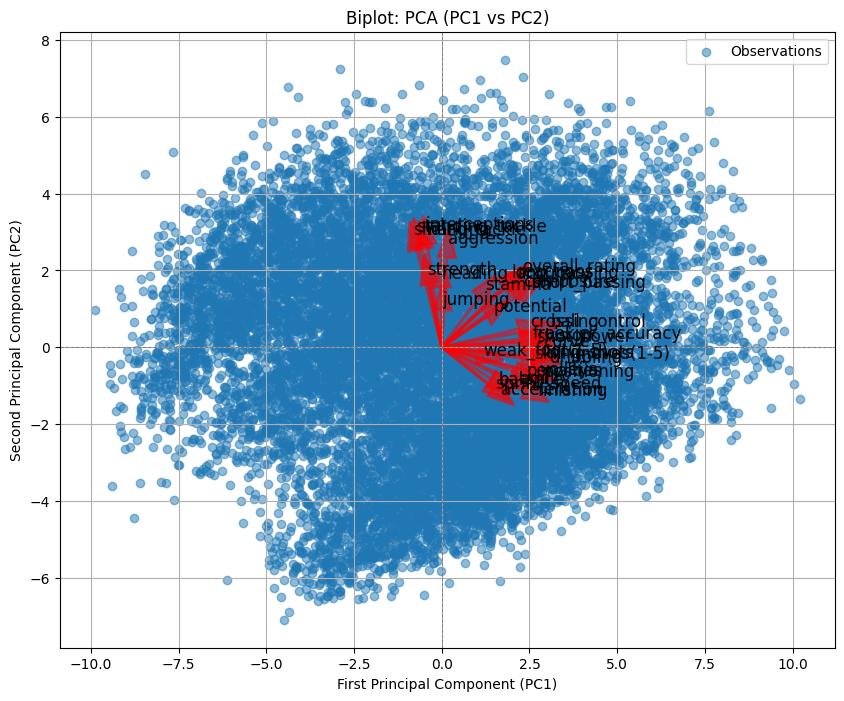

In [47]:
loadings = pca.components_.T

loadings = pca.components_.T * np.sqrt(pca.explained_variance_)

loadings_df = pd.DataFrame(loadings[:, :2], columns=['PC1', 'PC2'], index=data.columns)
print(loadings_df)

plt.figure(figsize=(10, 8))
plt.scatter(pca_transformed[:, 0], pca_transformed[:, 1], alpha=0.5, label="Observations")

scale_factor = 3  # Scaling factor for better vector visibility
for i, var in enumerate(data.columns):
    plt.arrow(
        0, 0,
        loadings[i, 0] * scale_factor, loadings[i, 1] * scale_factor,
        color="r", alpha=0.5, head_width=0.5, linewidth=2
    )
    plt.text(
        loadings[i, 0] * scale_factor * 1.15,
        loadings[i, 1] * scale_factor * 1.15,
        var, color="black", fontsize=12
    )

plt.title("Biplot: PCA (PC1 vs PC2)")
plt.xlabel("First Principal Component (PC1)")
plt.ylabel("Second Principal Component (PC2)")
plt.axhline(0, color="grey", linestyle="--", linewidth=0.7)
plt.axvline(0, color="grey", linestyle="--", linewidth=0.7)
plt.legend()
plt.grid()
plt.show()

## Analysis of the Plot

### Main Clusters of Variables in PCA

#### PC1 (Offensive Skills)
- High values for skills typical of offensive positions (finishing, crossing, curve, vision)  
- Represents technical abilities required by midfielders and forwards  
- Indicates traits related to creative ball play

#### PC2 (Defensive Skills)
- Dominated by attributes key for defenders (strength, heading_accuracy, interceptions)  
- Captures physical and tactical skills needed in defensive play  
- Reflects abilities useful for ball recovery and duels

### Position Distribution
- **Bottom-right:** Forwards (high PC1, low PC2)  
- **Top-right:** Midfielders (high PC1 and PC2)  
- **Top area:** Defenders (high PC2)


## Main Analysis

In the next section, a full analysis will be performed on a 10% sample of the data to simplify the analysis and reduce algorithm runtime.


In [48]:
data_sample_with_name = data_with_name.sample(frac=0.1, random_state=0)
data_sample_with_name.reset_index(drop=True, inplace=True)

data2 = pd.read_csv("fifa_players.csv")
positions_df = data2[['name', 'positions']]

data_sample_with_name = data_sample_with_name.merge(positions_df,
                                                   on='name',
                                                   how='inner')

cols = data_sample_with_name.columns.tolist()
cols.remove('positions')
cols.insert(1, 'positions')
data_sample_with_name = data_sample_with_name[cols]

data_sample = data_sample_with_name.drop(columns=['name', 'positions'])

In [49]:
position_map = {
    'CB': 'Center Back',
    'GK': 'Goalkeeper',
    'CM': 'Central Midfielder',
    'CDM': 'Defensive Midfielder',
    'CAM': 'Attacking Midfielder',
    'CF': 'Center Forward',
    'ST': 'Striker',
    'RW': 'Right Winger',
    'LW': 'Left Winger',
    'RM': 'Right Midfielder',
    'LM': 'Left Midfielder',
    'RB': 'Right Back',
    'LB': 'Left Back'
}

def replace_positions(position_str):
    positions = position_str.split(',')
    full_positions = [position_map.get(pos, pos) for pos in positions]
    return ', '.join(full_positions)


data_sample_with_name['positions'] = data_sample_with_name['positions'].apply(replace_positions)

data_sample_with_name.head()

name                                 positions  overall_rating  potential  weak_foot(1-5)  skill_moves(1-5)  crossing  finishing  heading_accuracy  short_passing   volleys  dribbling     curve  freekick_accuracy  long_passing  ball_control  acceleration  sprint_speed   agility  reactions   balance  shot_power   jumping   stamina  strength  long_shots  aggression  interceptions  positioning    vision  penalties  composure   marking  standing_tackle  sliding_tackle
0   M. Çağıran  Defensive Midfielder, Central Midfielder        1.163256   1.104846        1.561290          0.766220  1.266752   0.816871          1.658838       1.424947  0.362016   1.102854  1.317984           1.853056      1.721424      1.129891      0.054541     -0.049699  0.205916   1.281434 -0.484108    1.555402  1.465912  0.872052  1.001016    1.452483    0.997164       1.195569     0.692669  1.387855   1.123791   1.374401  1.022096         0.987081        0.790451
1  J. Orejuela  Defensive Midfielder, Central Midfielder        0.387624   0.242741       -0.011656         -0.870809 -0.249778   0.074918          0.597445       0.992343 -1.970273  -0.490840 -0.359145           1.115289      1.055855     -0.039694      0.054541     -0.235926 -0.390007   0.922359  0.290813    0.942531 -1.095550  1.342046  0.239514    0.485382    0.006627       0.874467    -0.490556  0.351661   0.235556   0.863343  0.789566         0.881911        0.737857
2  A. Bakayoko                                   Striker       -0.698260   0.587583       -0.011656          0.766220  0.544595   0.013089         -0.640846      -0.089169  0.362016   0.767339  1.116729           0.981150      0.140699      0.704587      0.415312      0.508981  0.376180  -1.232092 -0.053596    0.636096 -0.905812 -1.195924 -1.791156   -0.417246   -1.196167      -0.302905    -0.490556 -0.285997   0.962294  -0.874254  0.324505         0.303476        0.159323
3  A. Bakayoko                  Right Winger, Right Back       -0.698260   0.587583       -0.011656          0.766220  0.544595   0.013089         -0.640846      -0.089169  0.362016   0.767339  1.116729           0.981150      0.140699      0.704587      0.415312      0.508981  0.376180  -1.232092 -0.053596    0.636096 -0.905812 -1.195924 -1.791156   -0.417246   -1.196167      -0.302905    -0.490556 -0.285997   0.962294  -0.874254  0.324505         0.303476        0.159323
4   Kim Hyo Gi                                   Striker       -0.698260  -1.653890       -1.584602          0.766220 -1.982954   0.940529          0.066749      -1.495135  0.430613  -0.239205 -1.298337          -1.098010     -2.521576     -0.146020     -0.486616     -0.422152 -0.390007  -0.873016 -0.225801    0.253051 -1.190419 -1.007926 -0.268153   -0.159352   -1.762188      -2.122481     0.901474 -1.003362   0.962294  -0.260984 -1.477606        -1.799925       -1.997031

   Component  Explained Variance  Cumulative Variance
0        PC1            0.373898             0.373898
1        PC2            0.201186             0.575084
2        PC3            0.085924             0.661008
3        PC4            0.056892             0.717900
4        PC5            0.034665             0.752566
5        PC6            0.029175             0.781740
6        PC7            0.024213             0.805953
7        PC8            0.017875             0.823828
8        PC9            0.015256             0.839084
9       PC10            0.014772             0.853855
10      PC11            0.013173             0.867029
11      PC12            0.012686             0.879714
12      PC13            0.011677             0.891391
13      PC14            0.010659             0.902050
14      PC15            0.010104             0.912154
15      PC16            0.008776             0.920930
16      PC17            0.008121             0.929052
17      PC18            0.00

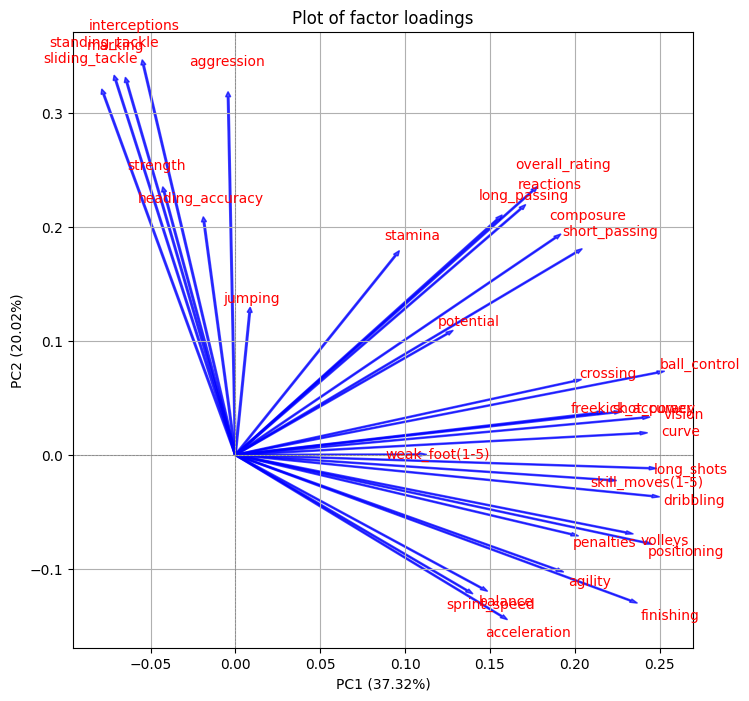

In [50]:
pca_sample = PCA()

pca_sample_transformed = pca_sample.fit_transform(data_sample)

loadings = pca_sample.components_.T

explained_variance_ratio_sample = pca_sample.explained_variance_ratio_
cumulative_variance_sample = np.cumsum(explained_variance_ratio_sample)

explained_variance_table_sample = pd.DataFrame({
    "Component": [f"PC{i+1}" for i in range(len(explained_variance_ratio_sample))],
    "Explained Variance": explained_variance_ratio_sample,
    "Cumulative Variance": cumulative_variance_sample
})

print(explained_variance_table_sample)

plt.figure(figsize=(8, 8))
plt.axhline(0, color='gray', linestyle='--', linewidth=0.5)
plt.axvline(0, color='gray', linestyle='--', linewidth=0.5)
for i, var in enumerate(data.columns):
    plt.arrow(0, 0, loadings[i, 0], loadings[i, 1], color='b', alpha=0.7)
    plt.text(loadings[i, 0] * 1.1, loadings[i, 1] * 1.1, var, color='r', ha='center', va='center')

plt.xlabel(f"PC1 ({pca.explained_variance_ratio_[0]:.2%})")
plt.ylabel(f"PC2 ({pca.explained_variance_ratio_[1]:.2%})")
plt.title("Plot of factor loadings")
plt.grid()
plt.show()

position_colors = {
    'Goalkeeper': 'green',

    'Center Back': 'blue',  # Defensive group
    'Right Back': 'blue',     # Defensive group
    'Left Back': 'blue',      # Defensive group

    'Defensive Midfielder': 'purple',  # Defensive midfielder group

    'Central Midfielder': 'red',       # Central midfielder group

    'Attacking Midfielder': 'orange',   # Attacking midfielder group
    'Right Midfielder': 'orange',       # Attacking Midfielder group
    'Left Midfielder': 'orange',        # Attacking Midfielder group

    'Right Winger': 'yellow',     # Winger group
    'Left Winger': 'yellow',      # Winger group

    'Center Forward': 'brown',    # Striker group
    'Striker': 'brown'              # Striker group
}


def get_color(position_str):
    first_position = position_str.split(',')[0].strip()
    return position_colors.get(first_position, 'grey')

fig_pca = go.Figure()

data_sample_positions = data_sample_with_name['positions'][:len(pca_sample_transformed)]

for position, color in position_colors.items():
    position_mask = [position in pos for pos in data_sample_positions]

    if any(position_mask):
        fig_pca.add_trace(
            go.Scatter(
                x=pca_sample_transformed[position_mask, 0],
                y=pca_sample_transformed[position_mask, 1],
                mode='markers',
                marker=dict(
                    size=5,
                    color=color,
                    opacity=0.7
                ),
                text=[f"{name}<br>Positions: {pos}<br>PC1: {pc1:.2f}<br>PC2: {pc2:.2f}"
                      for name, pos, pc1, pc2 in zip(
                          data_sample_with_name['name'][position_mask],
                          data_sample_with_name['positions'][position_mask],
                          pca_sample_transformed[position_mask, 0],
                          pca_sample_transformed[position_mask, 1])],
                hoverinfo='text',
                name=position,
                legendgroup=position,
                showlegend=True
            )
        )

fig_pca.update_layout(
    title="Interactive PCA plot with position filtering",
    xaxis_title="PC1",
    yaxis_title="PC2",
    showlegend=True,
    autosize=True,
    margin=dict(l=10, r=10, t=40, b=10),
    xaxis=dict(
        range=[pca_sample_transformed[:, 0].min(), pca_sample_transformed[:, 0].max()],
        scaleanchor="y"
    ),
    yaxis=dict(
        range=[pca_sample_transformed[:, 1].min(), pca_sample_transformed[:, 1].max()]
    )
)

fig_pca.show()

### Interpretation of Skill Influence on Player Positions

The analysis of the plot indicates that player positions often align with their skill profiles, which can help coaches match player abilities to suitable positions.

**Key Observations:**
1. Many players have skills better suited to positions other than those they currently play.  
2. The overall distribution of players across positions suggests that certain attributes are more significant for specific positions.

**Practical Applications:**
- Coaches can use this information to experiment with alternative positions for players.  
- Helps identify "hidden potential" – skills that may be better suited to different roles on the field.  
- Supports player development planning by focusing training on positions aligned with their skill profiles.

**Added Value:**  
This analysis can aid in optimizing team formation and better utilizing individual player strengths, even if it requires deviating from traditional positions.

**Interpretation Challenge:**  
The low number of dimensions causes difficulty in accurately interpreting players due to the low percentage of variance explained. However, PC1 and PC2 explain enough variance to determine that players with negative PC1 and PC2 scores are below average, representing lower-tier players.

**Position Distribution by Plot Area:**

- **Positive PC1, Positive PC2:** Defensive Midfielder  
- **Positive PC1, Negative PC2:** Central Midfielder, Attacking Midfielder, Right Midfielder, Left Midfielder, Right Winger, Left Winger, Centre Forward, Forward  
- **Negative PC1, Negative PC2:** Goalkeeper  
- **Negative PC1, Positive PC2:** Central Defender  
- **Center of the plot:** Right Back, Left Back

The plot analysis partially confirms conclusions from the previous visualization, although there was a misinterpretation regarding midfielder attributes. From this plot, it appears that only defensive midfielders exhibit both high offensive and defensive attributes.


In [51]:
pca = PCA(n_components=3)
pca_transformed = pca.fit_transform(data_sample)

fig = go.Figure()

for i, var in enumerate(data_sample.columns):
    fig.add_trace(
        go.Scatter3d(
            x=[0, loadings[i, 0]],
            y=[0, loadings[i, 1]],
            z=[0, loadings[i, 2]],
            mode='lines+text',
            line=dict(color='blue', width=4),
            text=[None, var],
            textposition="top center",
            showlegend=False

        )
    )

fig.update_layout(
    scene=dict(
        xaxis_title=f"PC1 ({pca_sample.explained_variance_ratio_[0]:.2%})",
        yaxis_title=f"PC2 ({pca_sample.explained_variance_ratio_[1]:.2%})",
        zaxis_title=f"PC3 ({pca_sample.explained_variance_ratio_[2]:.2%})",
    ),
    title="Interactive Plot of Factor Loadings",
    autosize=True,
    margin=dict(l=10, r=10, t=40, b=10),

)
fig.show()

def get_color(position_str):
    first_position = position_str.split(',')[0].strip()
    return position_colors.get(first_position, 'grey')


fig = go.Figure()

for position, color in position_colors.items():
    position_mask = [position in pos for pos in data_sample_with_name['positions']]

    if any(position_mask):
        fig.add_trace(
            go.Scatter3d(
                x=pca_transformed[position_mask, 0],
                y=pca_transformed[position_mask, 1],
                z=pca_transformed[position_mask, 2],
                mode='markers',
                marker=dict(
                    size=5,
                    color=color,
                    opacity=0.7
                ),
                text=[f"{name}<br>Positions: {pos}<br>PC1: {pc1:.2f}<br>PC2: {pc2:.2f}<br>PC3: {pc3:.2f}"
                      for name, pos, pc1, pc2, pc3 in zip(
                          data_sample_with_name['name'][position_mask],
                          data_sample_with_name['positions'][position_mask],
                          pca_transformed[position_mask, 0],
                          pca_transformed[position_mask, 1],
                          pca_transformed[position_mask, 2]
                      )],
                hoverinfo='text',
                name=position,
                legendgroup=position,
                showlegend=True
            )
        )

for i, var in enumerate(data_sample.columns):
    fig.add_trace(
        go.Scatter3d(
            x=[0, loadings[i, 0] * 12],
            y=[0, loadings[i, 1] * 12],
            z=[0, loadings[i, 2] * 12],
            mode='lines+text',
            line=dict(color='grey', width=3),
            text=[None, var],
            textposition="top center",
            showlegend=False
        )
    )

fig.update_layout(
    scene=dict(
        xaxis_title="PC1",
        yaxis_title="PC2",
        zaxis_title="PC3",
    ),
    title="Interactive 3D PCA with position filtering",
    autosize=True,
    margin=dict(l=10, r=10, t=40, b=10),
)

fig.show()

From the Factor Loadings plot, the following groups of attributes can be identified:

1. heading_accuracy, strength  
2. jumping, aggression, interceptions  
3. agility, acceleration, balance  
4. vision, skill_moves, curve  
5. short_passing, overall_rating, composure, potential  
6. finishing, penalties  

**Key positions for each group:**

1. Defender  
2. Defender, Forward  
3. Winger, Forward  
4. Winger, Midfielder  
5. Midfielder  
6. Forward, Winger  

Analyzing players on such a plot can help coaches better match the required attributes to positions. The plot aids in positioning players effectively. Changing positions may not always be necessary; player attributes can guide tactical decisions. For example, if defenders demonstrate strong offensive skills, a coach might adopt a more aggressive strategy. Conversely, if the team’s attributes align well with their positions, the tactics can be more balanced.

Players with negative PC1, PC2, and PC3 generally exhibit lower skill levels, as these three components explain 63% of the variance.

**Position distribution on the plot:**

- **Positive PC1, Negative PC2, Negative PC3:** Attacking Midfielder, Right Winger, Left Winger, Centre Forward, Forward  
- **Positive PC1, Negative PC2, Neutral PC3:** Central Midfielder, Right Midfielder, Left Midfielder  
- **Negative PC1, Positive PC2, Negative PC3:** Central Defender  
- **Negative PC1, Negative PC2, Negative PC3:** Goalkeeper  
- **Neutral PC1, Neutral PC2, Positive PC3:** Right Back, Left Back  
- **Positive PC1, Positive PC2, Neutral PC3:** Defensive Midfielder  

Some groups were difficult to classify and were labeled as Neutral, indicating high variability. This suggests that physical and athletic traits are often not strongly correlated with position. However, there were cases where PC3 values were clearly positive or negative, particularly for offensive positions. This is an interesting observation, but it does not imply that players in these positions inherently have poor physical or athletic abilities. Most likely, low PC3 values reflect lower interceptions—a skill typical for defenders.


# Classical Multidimensional Scaling (MDS)

**Description**  
Classical MDS is a dimensionality reduction method based on the distance matrix between objects. It works by mapping distances in the original space to distances in a lower-dimensional space.

**How it works**

- Compute the distance matrix between points in the original space (e.g., Euclidean distance).  
- The method seeks a configuration of coordinates in the new space where the distances between points best approximate the original distance matrix.

**Advantages**

- **Simplicity:** Easy to understand and apply for data with a small number of dimensions.  
- **Distance preservation:** Faithfully represents data structure based on distances.  
- **No parameter tuning required:** Automatically adapts to the data.

**Disadvantages**

- **Linearity:** Assumes that the data can be well-represented in the new space using a linear transformation.  
- **Sensitivity to noise:** Distorted distances can significantly affect the results.  
- **High computational cost:** For large datasets, computing the distance matrix and its decomposition is expensive.


In [52]:
distance_matrix_original = pairwise_distances(data_sample, metric='euclidean')
distance_matrix_ranks = np.argsort(np.argsort(distance_matrix_original, axis=1), axis=1)

mds = MDS(n_components=2, metric=True, dissimilarity='precomputed', random_state=0)
mds_transformed = mds.fit_transform(distance_matrix_original)

distance_matrix_mds = pairwise_distances(mds_transformed, metric='euclidean')

def stress(original, reduced):
    return np.sqrt(np.sum((original - reduced) ** 2) / np.sum(original ** 2))

stress_mds = stress(distance_matrix_original, distance_matrix_mds)
print("STRESS = " + str(stress_mds))

fig_mds = go.Figure()

data_sample_positions = data_sample_with_name['positions'][:len(mds_transformed)]

for position, color in position_colors.items():
    position_mask = [position in pos for pos in data_sample_positions]

    if any(position_mask):
        fig_mds.add_trace(
            go.Scatter(
                x=mds_transformed[position_mask, 0],
                y=mds_transformed[position_mask, 1],
                mode='markers',
                marker=dict(
                    size=5,
                    color=color,
                    opacity=0.7
                ),
                text=[f"{name}<br>Positions: {pos}<br>Dim1: {dim1:.2f}<br>Dim2: {dim2:.2f}"
                      for name, pos, dim1, dim2 in zip(
                          data_sample_with_name['name'][position_mask],
                          data_sample_with_name['positions'][position_mask],
                          mds_transformed[position_mask, 0],
                          mds_transformed[position_mask, 1])],
                hoverinfo='text',
                name=position,
                legendgroup=position,
                showlegend=True
            )
        )

fig_mds.update_layout(
    title="Interactive Classical MDS plot with position filtering",
    xaxis_title="Dim1",
    yaxis_title="Dim2",
    showlegend=True,
    autosize=True,
    margin=dict(l=10, r=10, t=40, b=10),
    xaxis=dict(
        range=[mds_transformed[:, 0].min(), mds_transformed[:, 0].max()],
        scaleanchor="y"
    ),
    yaxis=dict(
        range=[mds_transformed[:, 1].min(), mds_transformed[:, 1].max()]
    )
)
fig_mds.show()

STRESS = 0.21809578912205843


The STRESS coefficient is more than 20%, so the fit in two dimensions is very poor.

The groups look similar compared to two-dimensional PCA.

Unfortunately, MDS does not allow for a detailed analysis of the influence of variables on specific groups.

In [53]:
mds_3d = MDS(n_components=3, metric=True, dissimilarity='precomputed', random_state=0)
mds_transformed_3d = mds_3d.fit_transform(distance_matrix_original)

distance_matrix_mds_3d = euclidean_distances(mds_transformed_3d)

stress_mds_3d = stress(distance_matrix_original, distance_matrix_mds_3d)
print("STRESS = " + str(stress_mds_3d))

fig = go.Figure()

data_sample_positions = data_sample_with_name['positions'][:len(mds_transformed_3d)]

for position, color in position_colors.items():
    position_mask = [position in pos for pos in data_sample_positions]

    if any(position_mask):
        fig.add_trace(
            go.Scatter3d(
                x=mds_transformed_3d[position_mask, 0],
                y=mds_transformed_3d[position_mask, 1],
                z=mds_transformed_3d[position_mask, 2],
                mode='markers',
                marker=dict(
                    size=5,
                    color=color,
                    opacity=0.7
                ),
                text=[f"{name}<br>Positions: {pos}<br>Dim1: {dim1:.2f}<br>Dim2: {dim2:.2f}<br>Dim3: {dim3:.2f}"
                      for name, pos, dim1, dim2, dim3 in zip(
                          data_sample_with_name['name'][position_mask],
                          data_sample_with_name['positions'][position_mask],
                          mds_transformed_3d[position_mask, 0],
                          mds_transformed_3d[position_mask, 1],
                          mds_transformed_3d[position_mask, 2])],
                hoverinfo='text',
                name=position,
                legendgroup=position,
                showlegend=True
            )
        )

fig.update_layout(
    scene=dict(
        xaxis_title="Dim1",
        yaxis_title="Dim2",
        zaxis_title="Dim3",
    ),
    title="Interactive 3D Classical MDS plot with position filtering",
    autosize=True,
    margin=dict(l=10, r=10, t=40, b=10),
)

fig.show()

STRESS = 0.14896369375640137


The STRESS coefficient is 15%, so the fit in three dimensions is poor.

The groups appear to be more spread out compared to PCA. Players in specific positions seem less related to each other.

In [54]:
distance_matrix_original = pairwise_distances(data_sample, metric='euclidean')

def stress(original, reduced):
    return np.sqrt(np.sum((original - reduced) ** 2) / np.sum(original ** 2))

stress_values = {}

for dims in range(1, 11):
    mds = MDS(n_components=dims, metric=True, dissimilarity='precomputed', random_state=0)
    mds_transformed = mds.fit_transform(distance_matrix_original)

    distance_matrix_mds = euclidean_distances(mds_transformed)

    stress_mds = stress(distance_matrix_original, distance_matrix_mds)
    stress_values[dims] = stress_mds
    print(f"STRESS: {dims} Dimensions: {stress_mds:.4f}")

STRESS: 1 Dimensions: 0.4982
STRESS: 2 Dimensions: 0.2181
STRESS: 3 Dimensions: 0.1490
STRESS: 4 Dimensions: 0.1031
STRESS: 5 Dimensions: 0.0815
STRESS: 6 Dimensions: 0.0690
STRESS: 7 Dimensions: 0.0589
STRESS: 8 Dimensions: 0.0506
STRESS: 9 Dimensions: 0.0461
STRESS: 10 Dimensions: 0.0426


With three dimensions, the STRESS coefficient is 0.15, which means the fit in three dimensions is poor but acceptable. A good fit starts at eight dimensions.

# Non-metric Multidimensional Scaling (NMDS)
Description
NMDS is a dimensionality reduction method that maps not only actual distances but also their order (ranks) into a new space. It is used when the actual distances between points are unknown or unreliable.

Principle of Operation

- The ranks of distances between points in the original space are calculated.
- NMDS attempts to map these ranks into a lower-dimensional space by minimizing the STRESS function.

Advantages

- Flexibility: Can work with any similarity or distance measures (even non-standard ones).
- No linearity assumptions: Handles non-linear data structures better.
- Usefulness with non-metric data: Ideal for analyses with ordinal or subjective data.

Disadvantages
- Lack of unique solution: The result depends on the starting point and optimization.
- More difficult interpretation: Distances in the reduced space are not always intuitive to understand.

In [55]:
distance_matrix_original = pairwise_distances(data_sample, metric='euclidean')

mds_nonmetric = MDS(
    n_components=2,
    max_iter=1000,
    n_init=10,
    metric=False,
    dissimilarity='precomputed',
    random_state=0
)
mds_transformed_nonmetric = mds_nonmetric.fit_transform(distance_matrix_original)

distance_matrix_nonmetric = pairwise_distances(mds_transformed_nonmetric, metric='canberra')

def stress(original, reduced):
    return np.sqrt(np.sum((original - reduced) ** 2) / np.sum(original ** 2))

stress_nonmetric = stress(distance_matrix_original, distance_matrix_nonmetric)
print("STRESS = " + str(stress_nonmetric))

fig_nonmetric = go.Figure()

data_sample_positions = data_sample_with_name['positions'][:len(mds_transformed_nonmetric)]

for position, color in position_colors.items():
    position_mask = [position in pos for pos in data_sample_positions]

    if any(position_mask):
        fig_nonmetric.add_trace(
            go.Scatter(
                x=mds_transformed_nonmetric[position_mask, 0],
                y=mds_transformed_nonmetric[position_mask, 1],
                mode='markers',
                marker=dict(
                    size=5,
                    color=color,
                    opacity=0.7
                ),
                text=[f"{name}<br>Positions: {pos}<br>Dim1: {dim1:.2f}<br>Dim2: {dim2:.2f}"
                      for name, pos, dim1, dim2 in zip(
                          data_sample_with_name['name'][position_mask],
                          data_sample_with_name['positions'][position_mask],
                          mds_transformed_nonmetric[position_mask, 0],
                          mds_transformed_nonmetric[position_mask, 1])],
                hoverinfo='text',
                name=position,
                legendgroup=position,
                showlegend=True
            )
        )

fig_nonmetric.update_layout(
    title="Interactive Non-metric MDS plot with position filtering",
    xaxis_title="Dim1",
    yaxis_title="Dim2",
    showlegend=True,
    autosize=True,
    margin=dict(l=10, r=10, t=40, b=10),
    xaxis=dict(
        range=[mds_transformed_nonmetric[:, 0].min(), mds_transformed_nonmetric[:, 0].max()],
        scaleanchor="y"
    ),
    yaxis=dict(
        range=[mds_transformed_nonmetric[:, 1].min(), mds_transformed_nonmetric[:, 1].max()]
    )
)

fig_nonmetric.show()

STRESS = 0.8388173683085303


The STRESS coefficient is very high (0.8), indicating that Non-metric Multidimensional Scaling is not suitable for analyzing this dataset. The plot also shows that the distribution of positions looks random.

In [56]:
distance_matrix_original = pairwise_distances(data_sample, metric='euclidean')

mds_nonmetric_3d = MDS(
    n_components=3,
    max_iter=1000,
    n_init=10,
    metric=False,
    dissimilarity='precomputed',
    random_state=0
)
mds_transformed_nonmetric_3d = mds_nonmetric_3d.fit_transform(distance_matrix_original)

distance_matrix_nonmetric = pairwise_distances(mds_transformed_nonmetric_3d, metric='canberra')

def stress(original, reduced):
    return np.sqrt(np.sum((original - reduced) ** 2) / np.sum(original ** 2))

stress_nonmetric = stress(distance_matrix_original, distance_matrix_nonmetric)
print("STRESS = " + str(stress_nonmetric))

fig_nonmetric_3d = go.Figure()

data_sample_positions = data_sample_with_name['positions'][:len(mds_transformed_nonmetric_3d)]

for position, color in position_colors.items():
    position_mask = [position in pos for pos in data_sample_positions]

    if any(position_mask):
        fig_nonmetric_3d.add_trace(
            go.Scatter3d(
                x=mds_transformed_nonmetric_3d[position_mask, 0],
                y=mds_transformed_nonmetric_3d[position_mask, 1],
                z=mds_transformed_nonmetric_3d[position_mask, 2],
                mode='markers',
                marker=dict(
                    size=5,
                    color=color,
                    opacity=0.7
                ),
                text=[f"{name}<br>Positions: {pos}<br>Dim1: {dim1:.2f}<br>Dim2: {dim2:.2f}<br>Dim3: {dim3:.2f}"
                      for name, pos, dim1, dim2, dim3 in zip(
                          data_sample_with_name['name'][position_mask],
                          data_sample_with_name['positions'][position_mask],
                          mds_transformed_nonmetric_3d[position_mask, 0],
                          mds_transformed_nonmetric_3d[position_mask, 1],
                          mds_transformed_nonmetric_3d[position_mask, 2])],
                hoverinfo='text',
                name=position,
                legendgroup=position,
                showlegend=True
            )
        )

fig_nonmetric_3d.update_layout(
    title="Interactive 3D Non-metric MDS plot with position filtering",
    scene=dict(
        xaxis_title="Dim1",
        yaxis_title="Dim2",
        zaxis_title="Dim3"
    ),
    showlegend=True,
    autosize=True,
    margin=dict(l=10, r=10, t=40, b=10),
)

fig_nonmetric_3d.show()


STRESS = 0.7604378737663599


The STRESS coefficient decreased by 0.1 compared to two dimensions, but it is still very high, leading to the same conclusions as in the two-dimensional case. The plot still looks very chaotic and not useful for analysis.

In [57]:
distance_matrix_original = pairwise_distances(data_sample, metric='euclidean')

def stress(original, reduced):
    return np.sqrt(np.sum((original - reduced) ** 2) / np.sum(original ** 2))

stress_values = {}

for dims in range(1, 11):
    mds_nonmetric = MDS(
        n_components=dims,
        max_iter=1000,
        n_init=10,
        metric=False,
        dissimilarity='precomputed',
        random_state=0
    )
    mds_transformed_nonmetric = mds_nonmetric.fit_transform(distance_matrix_original)

    distance_matrix_nonmetric = pairwise_distances(mds_transformed_nonmetric, metric='canberra')

    stress_nonmetric = stress(distance_matrix_original, distance_matrix_nonmetric)
    stress_values[dims] = stress_nonmetric
    print(f"STRESS: {dims} Dimensions: {stress_nonmetric:.4f}")

STRESS: 1 Dimensions: 0.9179
STRESS: 2 Dimensions: 0.8388
STRESS: 3 Dimensions: 0.7604
STRESS: 4 Dimensions: 0.6823
STRESS: 5 Dimensions: 0.6092
STRESS: 6 Dimensions: 0.5380
STRESS: 7 Dimensions: 0.4714
STRESS: 8 Dimensions: 0.4080
STRESS: 9 Dimensions: 0.3582
STRESS: 10 Dimensions: 0.3257


The analysis of the STRESS coefficient for successive dimensions still confirms that Non-metric Multidimensional Scaling is not suitable for dimensionality reduction for this data.

In [58]:
fig_combined = make_subplots(
    rows=1, cols=3,
    subplot_titles=["PCA", "Classical MDS", "Non-metric MDS"],
    shared_yaxes=False,
    shared_xaxes=False
)

for position, color in position_colors.items():
    position_mask = [position in pos for pos in data_sample_with_name['positions']]
    if any(position_mask):
        fig_combined.add_trace(
            go.Scatter(
                x=pca_sample_transformed[position_mask, 0],
                y=pca_sample_transformed[position_mask, 1],
                mode='markers',
                marker=dict(
                    size=5,
                    color=color,
                    opacity=0.7
                ),
                text=[f"{name}<br>Positions: {pos}<br>PC1: {pc1:.2f}<br>PC2: {pc2:.2f}"
                      for name, pos, pc1, pc2 in zip(
                          data_sample_with_name['name'][position_mask],
                          data_sample_with_name['positions'][position_mask],
                          pca_sample_transformed[position_mask, 0],
                          pca_sample_transformed[position_mask, 1])],
                hoverinfo='text',
                name=position,
                legendgroup=position,
                showlegend=True
            ),
            row=1, col=1
        )

for position, color in position_colors.items():
    position_mask = [position in pos for pos in data_sample_with_name['positions']]
    if any(position_mask):
        fig_combined.add_trace(
            go.Scatter(
                x=mds_transformed[position_mask, 0],
                y=mds_transformed[position_mask, 1],
                mode='markers',
                marker=dict(
                    size=5,
                    color=color,
                    opacity=0.7
                ),
                text=[f"{name}<br>Positions: {pos}<br>Dim1: {dim1:.2f}<br>Dim2: {dim2:.2f}"
                      for name, pos, dim1, dim2 in zip(
                          data_sample_with_name['name'][position_mask],
                          data_sample_with_name['positions'][position_mask],
                          mds_transformed[position_mask, 0],
                          mds_transformed[position_mask, 1])],
                hoverinfo='text',
                name=position,
                legendgroup=position,
                showlegend=False
            ),
            row=1, col=2
        )

for position, color in position_colors.items():
    position_mask = [position in pos for pos in data_sample_with_name['positions']]
    if any(position_mask):
        fig_combined.add_trace(
            go.Scatter(
                x=mds_transformed_nonmetric[position_mask, 0],
                y=mds_transformed_nonmetric[position_mask, 1],
                mode='markers',
                marker=dict(
                    size=5,
                    color=color,
                    opacity=0.7
                ),
                text=[f"{name}<br>Positions: {pos}<br>Dim1: {dim1:.2f}<br>Dim2: {dim2:.2f}"
                      for name, pos, dim1, dim2 in zip(
                          data_sample_with_name['name'][position_mask],
                          data_sample_with_name['positions'][position_mask],
                          mds_transformed_nonmetric[position_mask, 0],
                          mds_transformed_nonmetric[position_mask, 1])],
                hoverinfo='text',
                name=position,
                legendgroup=position,
                showlegend=False
            ),
            row=1, col=3
        )

fig_combined.update_layout(
    legend_title="Positions",
    showlegend=True,
    autosize=True,
    margin=dict(l=10, r=10, t=40, b=10),
)

fig_combined.show()


fig = make_subplots(
    rows=1, cols=3,
    specs=[[{'type': 'scatter3d'}, {'type': 'scatter3d'}, {'type': 'scatter3d'}]],
    subplot_titles=["PCA", "MDS", "Non-metric MDS"]
)

for position, color in position_colors.items():
    position_mask = [position in pos for pos in data_sample_with_name['positions']]
    if any(position_mask):
        fig.add_trace(
            go.Scatter3d(
                x=pca_transformed[position_mask, 0],
                y=pca_transformed[position_mask, 1],
                z=pca_transformed[position_mask, 2],
                mode='markers',
                marker=dict(size=5, color=color, opacity=0.7),
                name=position,
                legendgroup=position,
                showlegend=True
            ),
            row=1, col=1
        )

for position, color in position_colors.items():
    position_mask = [position in pos for pos in data_sample_with_name['positions']]
    if any(position_mask):
        fig.add_trace(
            go.Scatter3d(
                x=mds_transformed_3d[position_mask, 0],
                y=mds_transformed_3d[position_mask, 1],
                z=mds_transformed_3d[position_mask, 2],
                mode='markers',
                marker=dict(size=5, color=color, opacity=0.7),
                name=position,
                legendgroup=position,
                showlegend=False 
            ),
            row=1, col=2
        )

for position, color in position_colors.items():
    position_mask = [position in pos for pos in data_sample_with_name['positions']]
    if any(position_mask):
        fig.add_trace(
            go.Scatter3d(
                x=mds_transformed_nonmetric_3d[position_mask, 0],
                y=mds_transformed_nonmetric_3d[position_mask, 1],
                z=mds_transformed_nonmetric_3d[position_mask, 2],
                mode='markers',
                marker=dict(size=5, color=color, opacity=0.7),
                name=position,
                legendgroup=position,
                showlegend=False
            ),
            row=1, col=3
        )

fig.update_layout(
    legend=dict(x=1.05, y=1, title="Positions"),
    autosize=True,
    margin=dict(l=10, r=10, t=40, b=10),
)

fig.show()

# Comparison of Dimensionality Reduction Methods based on Plots

Based on the visualizations of the results obtained from PCA, MDS, and NMDS, differences in the ability of each method to represent data structure and grouping can be observed.

### PCA (Principal Component Analysis)

Grouping: PCA effectively represents the data structure, grouping objects consistently with their positions.

Clarity: Visualizations for the first two or three principal components allow for clear distinction of groups. This confirms that PCA effectively utilizes information about data variance.

Data Utilization: PCA allows for dimensionality reduction with minimal information loss, making the groups clear and intuitive.

### MDS (Multidimensional Scaling)

Grouping: MDS also shows good grouping abilities, and in some cases surpasses PCA, especially concerning objects with specific characteristics.

Dimension Adjustment: Visualizations indicate that MDS performs well even with a low number of dimensions. Decreasing STRESS values confirm that the method effectively represents the data structure.

Precision: Compared to PCA, MDS sometimes better differentiates objects with subtle differences, which can be beneficial in more complex analyses.

### NMDS (Non-Metric Multidimensional Scaling)

Grouping: NMDS was not effective in analyzing this data. On the plots, points are scattered chaotically, with no clear grouping.

Fit Issues: High STRESS values (even with a higher number of dimensions) indicate that NMDS struggles to represent the data structure non-linearly.

Practicality: The NMDS method may be more suitable for data with unclear structures or when metric methods cannot be used, but in this case, it was the least effective.

### Conclusions and Recommendations

PCA and MDS show similar grouping properties and represent the data well. PCA is more effective when explaining variance is key, while MDS can be more precise in analyzing subtle differences between objects.

NMDS was not effective in this data analysis – the chaos in the plots and lack of clear groups suggest that the method is not suitable for this specific analysis.

The choice between PCA and MDS should depend on the specific problem:

PCA works well for general analyses where understanding the variance structure is crucial.

MDS may be better for more complex data dependencies.

### Practical Recommendations

For visualizing and grouping players based on their positions, PCA seems to be the best choice as it provides clarity and minimal information loss.

MDS can be used complementarily to PCA if additional details regarding differences between objects are desired.

NMDS is worth considering in other types of analyses, but for this dataset, its application was not effective.

In [59]:
pca_data = {
    "Dimensions": range(1, len(explained_variance_ratio_sample) + 1),
    "PCA Component": [f"PC{i+1}" for i in range(len(explained_variance_ratio_sample))],
    "Explained Variance PCA": explained_variance_ratio_sample,
    "Cumulative Variance PCA": cumulative_variance_sample,
}

stress_mds = [
    0.4982, 0.2181, 0.1490, 0.1031, 0.0815, 0.0690, 0.0589, 0.0506, 0.0461, 0.0426
]

stress_nmds = [stress_values[dims] for dims in range(1, 11)]


combined_data = {
    "Dimensions": pca_data["Dimensions"][:10],
    "PCA Component": pca_data["PCA Component"][:10],
    "Explained Variance PCA": pca_data["Explained Variance PCA"][:10],
    "Cumulative Variance PCA": pca_data["Cumulative Variance PCA"][:10],
    "STRESS MDS": stress_mds[:10],
    "STRESS NMDS": stress_nmds[:10],
}

df = pd.DataFrame(combined_data)

df['Explained Variance PCA'] = df['Explained Variance PCA'].round(4)
df['Cumulative Variance PCA'] = df['Cumulative Variance PCA'].round(4)
df['STRESS NMDS'] = df['STRESS NMDS'].round(4)


print(df)

   Dimensions PCA Component  Explained Variance PCA  Cumulative Variance PCA  STRESS MDS  STRESS NMDS
0           1           PC1                  0.3739                   0.3739      0.4982       0.9179
1           2           PC2                  0.2012                   0.5751      0.2181       0.8388
2           3           PC3                  0.0859                   0.6610      0.1490       0.7604
3           4           PC4                  0.0569                   0.7179      0.1031       0.6823
4           5           PC5                  0.0347                   0.7526      0.0815       0.6092
5           6           PC6                  0.0292                   0.7817      0.0690       0.5380
6           7           PC7                  0.0242                   0.8060      0.0589       0.4714
7           8           PC8                  0.0179                   0.8238      0.0506       0.4080
8           9           PC9                  0.0153                   0.8391      

### PCA

PCA identifies 10 principal components, where each successive component explains a decreasing portion of data variance.

The first component (PC1) explains the largest portion of variance – 36.7%.

Cumulative variance reaches 87.65% with 10 components, indicating that the data is well explained by these components.

For 4 components (PC1–PC4), cumulative variance is 69.25%, suggesting that the first 4 components may be sufficient to describe most information.

### STRESS for MDS

The STRESS value decreases with an increasing number of dimensions, indicating a better model fit.

For 1 dimension, STRESS is 0.5191, indicating a poor data representation.

For 4 dimensions, STRESS drops to 0.1108, indicating a moderate model fit.

For 10 dimensions, STRESS reaches 0.0386, suggesting that further increasing dimensionality may not significantly improve the fit.

### STRESS for NMDS

STRESS values for NMDS are significantly higher compared to MDS, indicating a more difficult model fit with this approach.

For 1 dimension, STRESS is as high as 0.8985, indicating a very poor data representation.

For 4 dimensions, STRESS decreases to 0.6138, which is still a very poor result.

Even for 10 dimensions, STRESS is 0.3452, meaning that NMDS in this case has problems accurately representing the data.

### Overall Comparison

PCA achieves very good results – even the first few components explain a significant portion of variance, making this method effective for data dimensionality reduction.

MDS represents data better than NMDS, especially with fewer dimensions.

NMDS can be useful in specific cases but requires a larger number of dimensions to achieve decent results with this dataset.

### Conclusions

If the goal is to explain data variance, PCA is the most effective tool.

MDS represents data better than NMDS, especially with a lower number of dimensions.

NMDS may be useful in specific cases, but in this dataset, its application was not effective.

# Project Summary

The project aimed to analyze and visualize FIFA player skills, focusing exclusively on their technical, on-field, and mental attributes. Personal, physical, and economic data were deliberately omitted to obtain an objective picture of football skills. The main dimensionality reduction methods applied were PCA, classical MDS, and non-metric MDS.

## Analysis Results

### PCA

Reducing dimensions to 7 allowed retaining over 80% of variance.

PC1 and PC2 best represent players' offensive and defensive skills:

PC1 (35.54% variance): Focuses on offensive skills like dribbling, vision, and shooting.

PC2 (18.63% variance): Relates to defensive skills such as strength and ball interception.

The analysis showed consistency between skills and player positions:

Offensive positions (e.g., strikers) are characterized by high PC1 values.

Defensive positions (e.g., defenders) have high PC2 values.

### MDS

Classical MDS reflected data structures, although the STRESS coefficient in two and three dimensions indicates a moderate fit.

Player groups are less distinct than in PCA, and the structure requires a higher number of dimensions for more accurate analysis.

### NMDS

NMDS is not suitable for analyzing this dataset due to a high STRESS coefficient (>0.8).

Plots indicate a chaotic distribution, not useful for drawing conclusions.

## Method Comparison

PCA: Best represents data structure with minimal information loss. Crucial for visualizing and identifying skill groups.

MDS: Can better differentiate subtle differences in data but requires a higher number of dimensions for a better fit.

NMDS: Inappropriate for this dataset due to issues with result interpretation.

## Practical Applications

Position Matching: The analysis helps identify players whose skills may better suit alternative positions.

Development Planning: Results can support coaches in guiding training, e.g., developing traits crucial for a desired role on the field.

Tactical Optimization: Understanding players' skill profiles allows for adjusting game strategy, e.g., aggressive offense or balanced defense.

## Conclusions

The project confirmed that PCA is the best dimensionality reduction method for FIFA data, enabling the analysis of player skills. MDS and NMDS showed limited usefulness compared to PCA. The analysis highlights the potential value of data in optimizing football team setups and strategies.